In [5]:
!pip install torch_geometric

# Optional dependencies:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.4.0+cu122.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.0 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.4.0+cu122.html
ERROR: Could not find a version that satisfies the requirement pyg_lib (from versions: none)
ERROR: No matching distribution found for pyg_lib


In [22]:
from torch_geometric import datasets
import networkx as nx
import matplotlib.pyplot as plt


In [35]:
def visualize_graph(G,color):
  plt.figure(figsize=(7,7))
  plt.xticks([])
  plt.yticks([])
  nx.draw_networkx(G, pos=nx.spring_layout(G,seed=42),with_labels=False,
                   node_color=color,cmap="Set2")
  plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7, 7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")  # 修改这里
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

In [7]:
data = datasets.KarateClub()

34
4
Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


In [10]:
print(f'Number of graphs:{len(data)}') #图的个数
print(f'Number of features:{data.num_features}') #每个点向量的维度
print(f'Number of classes:{data.num_classes}') #分类的类别数

Number of graphs:1
Number of features:34
Number of classes:4


In [11]:
data1 = data[0] #因为只有一个图，所有把第一个图取出来
print(data1) #表示34个点，每个点的特征向量是34维，链接矩阵是[2,156]，每一个点有一个输出，共有34个输出，但是其中有部分可能是none，
#train_mask,把有输出的变成true，没输出的变成false

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


In [41]:
print(data1.x.shape)

torch.Size([34, 34])


In [13]:
edge_index = data1.edge_index
print(edge_index.t())

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

In [18]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    torch.manual_seed(1234)
    self.conv1 = GCNConv(data.num_features,4)
    self.conv2 = GCNConv(4,4)
    self.conv3 = GCNConv(4,2)
    self.classifier = Linear(2,data.num_classes)

  def forward(self,x,edge_index): #这里的x可能是特征向量
    h = self.conv1(x,edge_index)
    h = h.tanh()
    h = self.conv2(h,edge_index)
    h = h.tanh()
    h = self.conv3(h,edge_index)
    h = h.tanh()

    out = self.classifier(h)

    return out,h

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


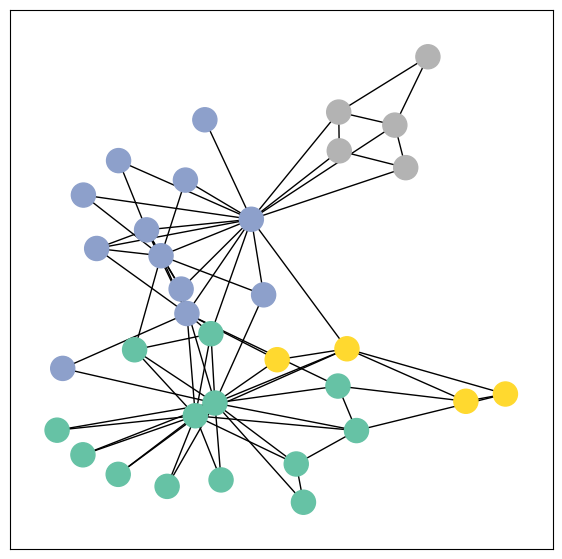

In [36]:
from torch_geometric.utils import to_networkx

G = to_networkx(data1,to_undirected=True)

visualize_graph(G, color=data1.y)

Embedding shape:[34, 2]


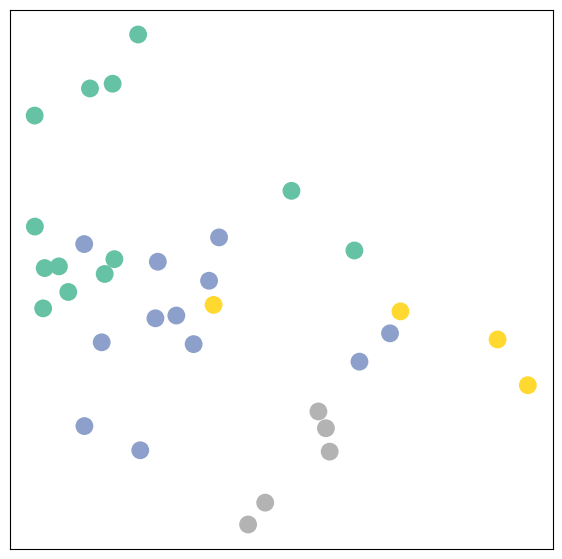

In [28]:
model = GCN()
_,h = model(data1.x,data1.edge_index) #输入时特征所有点的特征和链接矩阵
print(f'Embedding shape:{list(h.shape)}')

visualize_embedding(h, color=data1.y)

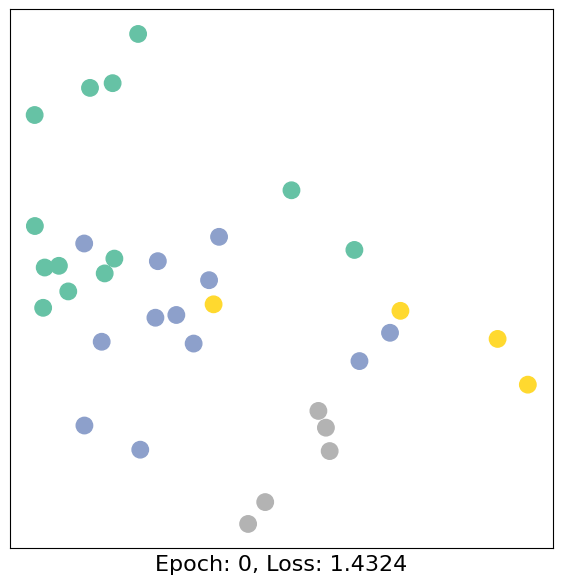

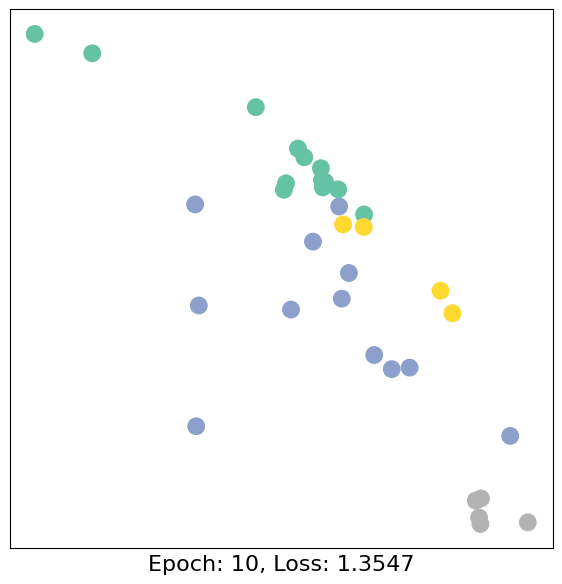

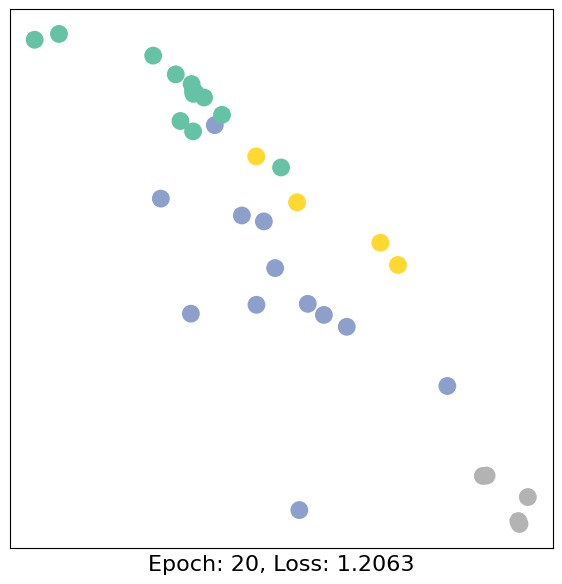

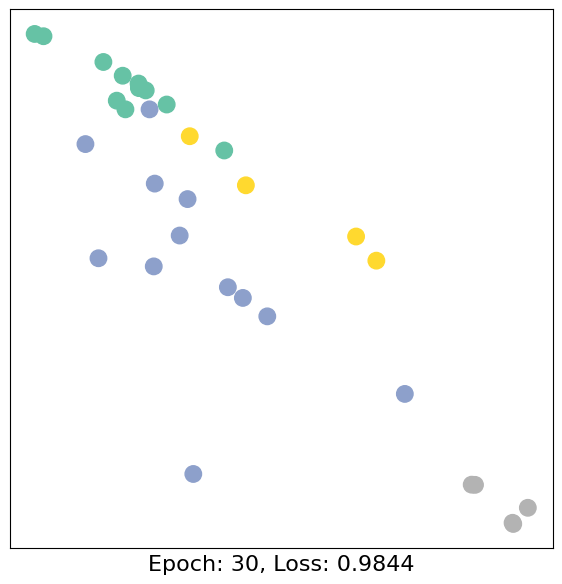

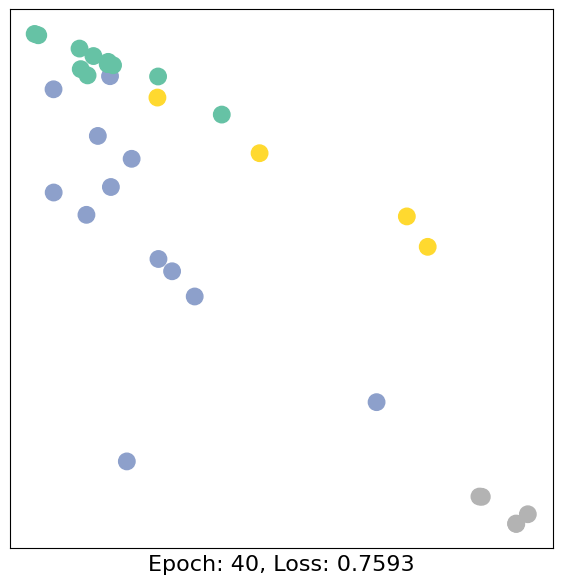

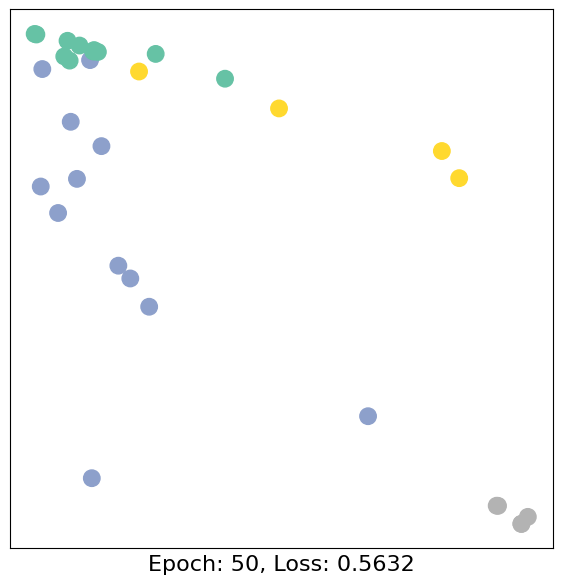

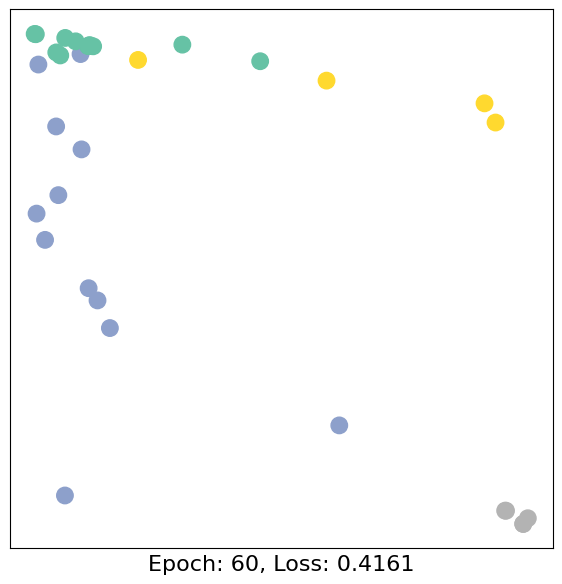

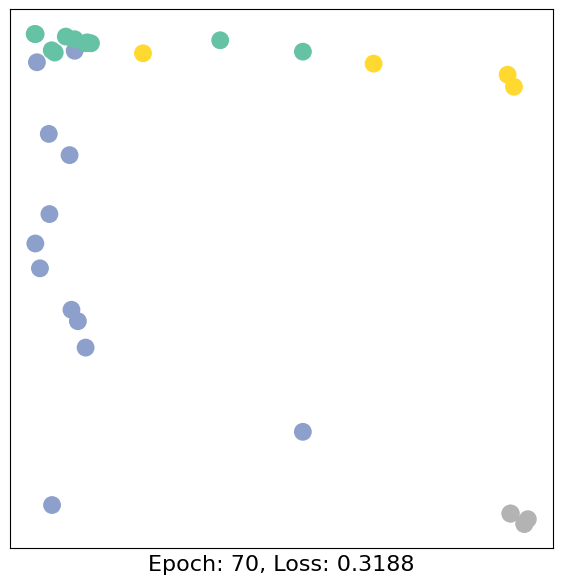

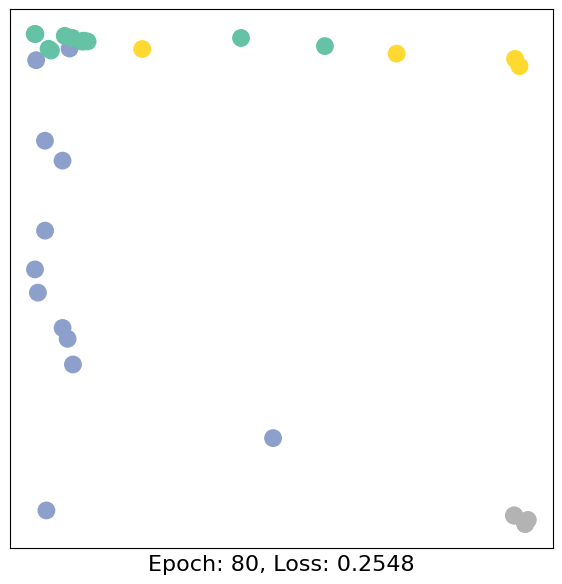

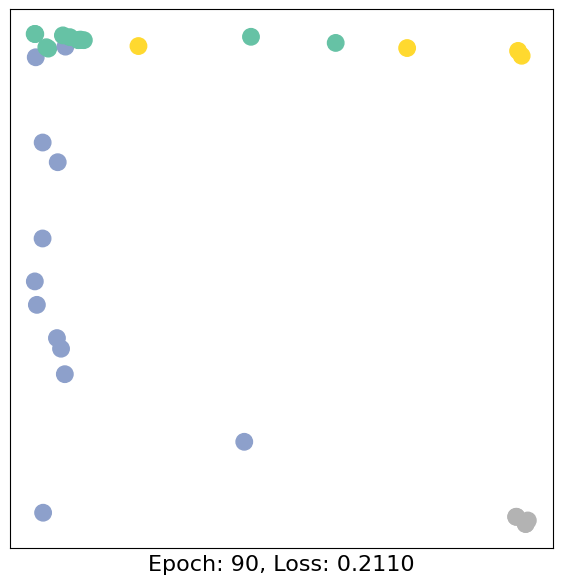

In [42]:
#训练模型
import time
model = GCN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

def train(data): #输入的是第一张图的数据
  optimizer.zero_grad()
  out,h = model(data1.x,data1.edge_index)
  loss = criterion(out[data.train_mask],data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  return loss,h

for epoch in range(100):
  loss,h = train(data1)
  if epoch % 10 == 0:
    visualize_embedding(h,color=data.y,epoch=epoch,loss=loss)
    time.sleep(0.3)